# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random 
from scipy import stats

# from ydata_profiling          import ProfileReport

# from sklearn.preprocessing    import MinMaxScaler,RobustScaler
# from sklearn.model_selection  import train_test_split, StratifiedKFold,RandomizedSearchCV
# from sklearn.model_selection  import cross_val_score, cross_validate

# from sklearn.ensemble         import RandomForestClassifier
# from sklearn.linear_model     import LogisticRegression,SGDClassifier
# from xgboost                  import XGBClassifier
# from sklearn.neighbors        import KNeighborsClassifier
# from lightgbm                 import LGBMClassifier

# from sklearn.metrics          import classification_report, cohen_kappa_score, roc_curve, brier_score_loss,roc_auc_score
# from sklearn.metrics          import accuracy_score, precision_score,recall_score,confusion_matrix,f1_score

# from sklearn.calibration      import CalibratedClassifierCV
# from sklearn.calibration      import calibration_curve

In [2]:
pd.set_option('display.max_columns',None)
# pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# Helper Functions

In [3]:
def ml_metrics( model_name, y_true, yhat):
    accuracy = accuracy_score(y_true, yhat)
    precision = precision_score(y_true, yhat)
    recall = recall_score(y_true, yhat)

    return pd.DataFrame({'Model Name': model_name, 
                        'ACC': accuracy,
                        'PRECISION': precision,
                        'RECALL': recall}, index = [0])

In [4]:
def model_cross_validation(model_name, model, X, y, threshold):
    skf = StratifiedKFold(n_splits=10)
    precision_list = []
    recall_list = []
    f1_list = []
    accuracy_list = []
    kappa_list = []
    auc_score_list = []

    for train_index, test_index in skf.split(X, y):
        x_train_fold, x_test_fold = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train_fold, y_test_fold = y.iloc[train_index,:], y.iloc[test_index,:]

        model.fit(x_train_fold, y_train_fold.values.ravel())
        
        probs = pd.DataFrame(model.predict_proba(x_test_fold)[:, 1], columns=['prob'])
        
        # applies the threshold
        y_hat = probs['prob'].apply(lambda x: 1 if x > threshold else 0)
        
        precision = precision_score(y_test_fold, y_hat)
        recall = recall_score(y_test_fold, y_hat)
        f1 = f1_score(y_test_fold, y_hat)
        accuracy = accuracy_score(y_test_fold, y_hat)
        kappa = cohen_kappa_score(y_test_fold, y_hat)
        auc_score = roc_auc_score(y_test_fold, probs)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        accuracy_list.append(accuracy)
        kappa_list.append(kappa)
        auc_score_list.append(auc_score)


    result = {'Model Name': model_name, 
                'Precision': round(100*np.mean(precision_list),2),
                'Recall': round(100*np.mean(recall_list),2),
                'F1-Score': round(100*np.mean(f1_list),2),
                'Accuracy': round(100*np.mean(accuracy_list),2),
                'Kappa': round(100*np.mean(kappa_list),2),
                'AUC': round(100*np.mean(auc_score_list),2)}
    return pd.DataFrame(result, index = [0])

In [5]:
def cramer_v(x, y):
    cm = pd.crosstab( x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape

    chi2 = stats.chi2_contingency( cm )[0]

    # correção bias V de Cramer
    chi2corr = max(0, chi2 - (k-1)*(r - 1) / (n-1))
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)

    v = np.sqrt( (chi2corr / n) / (min(kcorr-1, rcorr-1) ) )
    return v

# Carga dos Dados

In [6]:
path = '../data/'

In [7]:
df = pd.read_csv(path + 'Customer-Churn - Customer-Churn.csv',sep = ',')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"118,75","8672,45",No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,"118,65","8477,6",No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,"118,6","7990,05",No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,"118,6","7365,7",No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),"118,35","7804,15",Yes


# Descrição dos dados

## Renomear colunas

In [8]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Dimensão dos dados

In [9]:
print('Quantidade de: \nLinhas: {} \nColunas: {}'.format(df.shape[0],df.shape[1]))

Quantidade de: 
Linhas: 7043 
Colunas: 21


In [10]:
df['Churn'].value_counts(normalize=True)*100

No    73.463
Yes   26.537
Name: Churn, dtype: float64

Temos dados desbalanceados, uma vez que 26,6% dos dados são CHURN

## Tipos de dados

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   int64 
 3   Partner           7043 non-null   object
 4   Dependents        7043 non-null   object
 5   tenure            7043 non-null   int64 
 6   PhoneService      7043 non-null   object
 7   MultipleLines     7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  Contract          7043 non-null   object
 16  PaperlessBilling  7043 non-null   object
 17  PaymentMethod 

## Verificar NA

In [12]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

11 elementos nulos no TotalCharges

## Mudar o dtypes

In [13]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7569-NMZYQ,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),"118,75","8672,45",No
1,8984-HPEMB,Female,0,No,No,71,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,"118,65","8477,6",No
2,5989-AXPUC,Female,0,Yes,No,68,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Mailed check,"118,6","7990,05",No
3,5734-EJKXG,Female,0,No,No,61,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Electronic check,"118,6","7365,7",No
4,8199-ZLLSA,Male,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),"118,35","7804,15",Yes


In [14]:
df['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [15]:
# mudança nas variaveis string que possuem valores que se identificam como "No", porém escritos de outra forma (como "no phone")
cols_a_mudar = ['StreamingMovies','StreamingTV','MultipleLines','OnlineBackup','OnlineSecurity','DeviceProtection','TechSupport']

for i in cols_a_mudar:
    df.loc[df[i] != 'Yes', i ] = 'No'

In [16]:
# mudança das colunas que são float, porém vieram como string
for i in ['MonthlyCharges','TotalCharges']:
    df[i] = df[i].str.replace('.','').str.replace(',','.').astype(float)

## Replace NA

In [17]:
print("Antes do drop: {}".format(df.shape))

df = df.dropna()

print("Depois do drop: {}".format(df.shape))

Antes do drop: (7043, 21)
Depois do drop: (7032, 21)


## Estatística Descritiva

In [18]:
df1 = df.copy()

### Atributos Numéricos

In [19]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

In [20]:
# tendencias centrais
ct_mean = pd.DataFrame( num_attributes.apply( np.mean )).T
ct_median = pd.DataFrame( num_attributes.apply( np.median )).T

# dispesão
ct_std = pd.DataFrame( num_attributes.apply( np.std )).T
ct_min = pd.DataFrame( num_attributes.apply( np.min )).T
ct_max = pd.DataFrame( num_attributes.apply( np.max )).T
ct_range = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
ct_skew = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
ct_kurtosis = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

In [21]:
num_analysis = pd.concat([ct_min,ct_max,ct_mean, ct_median, ct_std, ct_range, ct_skew, ct_kurtosis]).T.reset_index()
num_analysis.columns = ['attributes','min','max','mean','median','std','range','skew','kurtosis']
num_analysis

# kurtosis > 0 -> it is more "narrowed" the distribution
# skew > 0 -> the distribution tend to be more on the right side (values above the 'mean')

,attributes,min,max,mean,median,std,range,skew,kurtosis
0,SeniorCitizen,0.000,1.000,0.162,0.000,0.369,1.000,1.831,1.353
1,tenure,1.000,72.000,32.422,29.000,24.544,71.000,0.238,-1.388
2,MonthlyCharges,18.250,118.750,64.798,70.350,30.084,100.500,-0.222,-1.256
3,TotalCharges,18.800,8684.800,2283.300,1397.475,2266.610,8666.000,0.962,-0.232


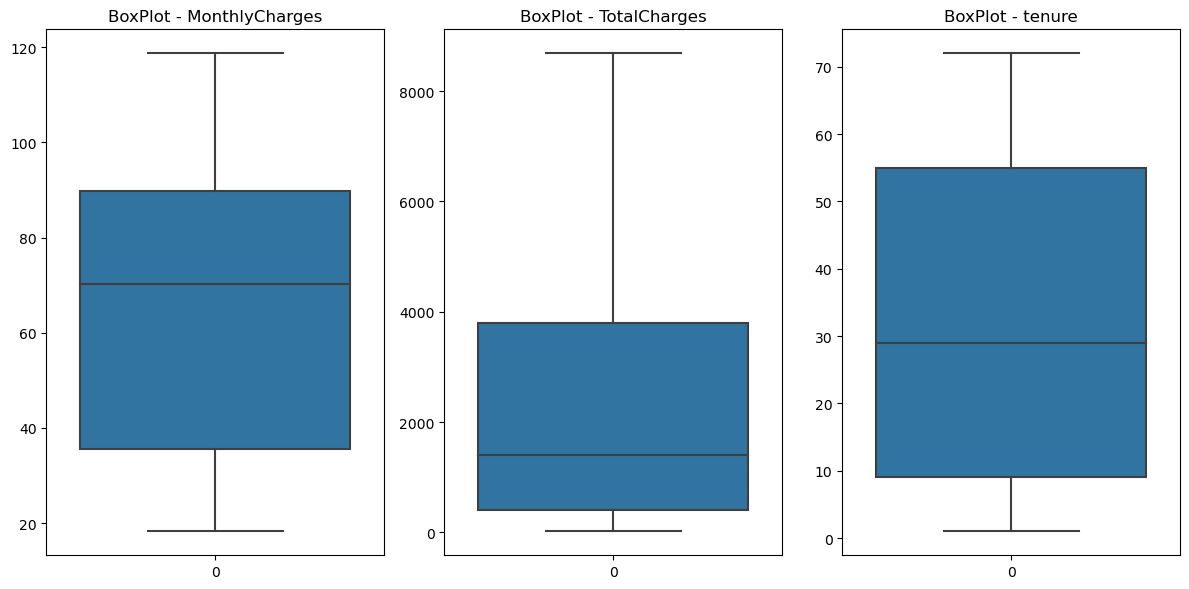

In [22]:
fig, axes = plt.subplots(1,3, figsize=(12,6))
cols = ['MonthlyCharges', 'TotalCharges', 'tenure']
for i,j in enumerate(cols):
    sns.boxplot(data = df[j], ax = axes[i]);
    axes[i].set_title('BoxPlot - '+ j)
plt.tight_layout();

Aparentemente, não há valores *outliers*

## Atributos Categóricos

In [23]:
cat_attributes = df1.select_dtypes(include=['object'])
cat_attributes.columns

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

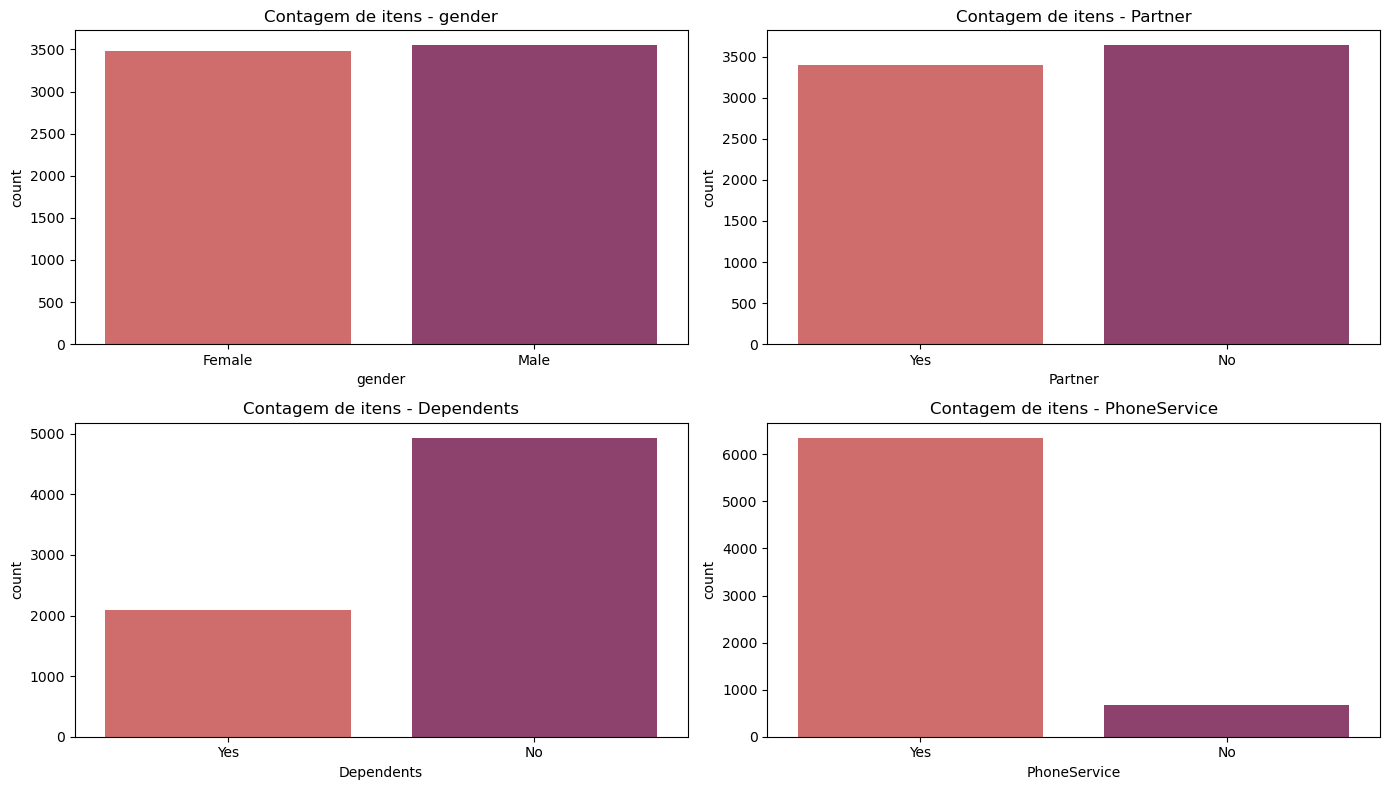

In [24]:
fig, axes = plt.subplots(2,2, figsize=(14,8))
cols = ['gender', 'Partner', 'Dependents', 'PhoneService']
for i,j in enumerate(cols):
    x,y = divmod(i, 2)
    sns.countplot(data = df1, x = j, palette='flare', ax = axes[x,y]);
    axes[x,y].set_title('Contagem de itens - '+ j)

plt.tight_layout();

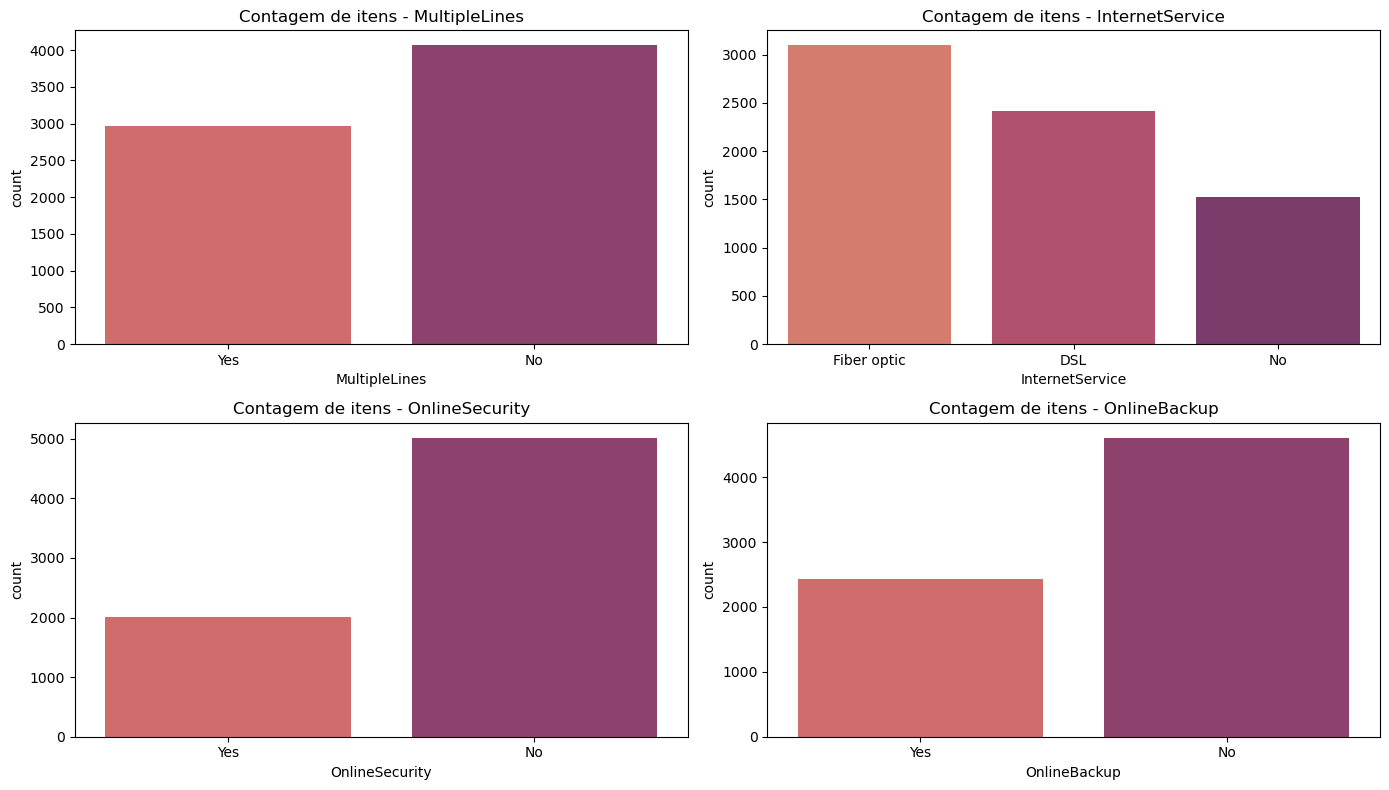

In [25]:
fig, axes = plt.subplots(2,2, figsize=(14,8))
cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup']
for i,j in enumerate(cols):
    x,y = divmod(i, 2)
    sns.countplot(data = df1, x = j, palette='flare', ax = axes[x,y]);
    axes[x,y].set_title('Contagem de itens - '+ j)

plt.tight_layout();

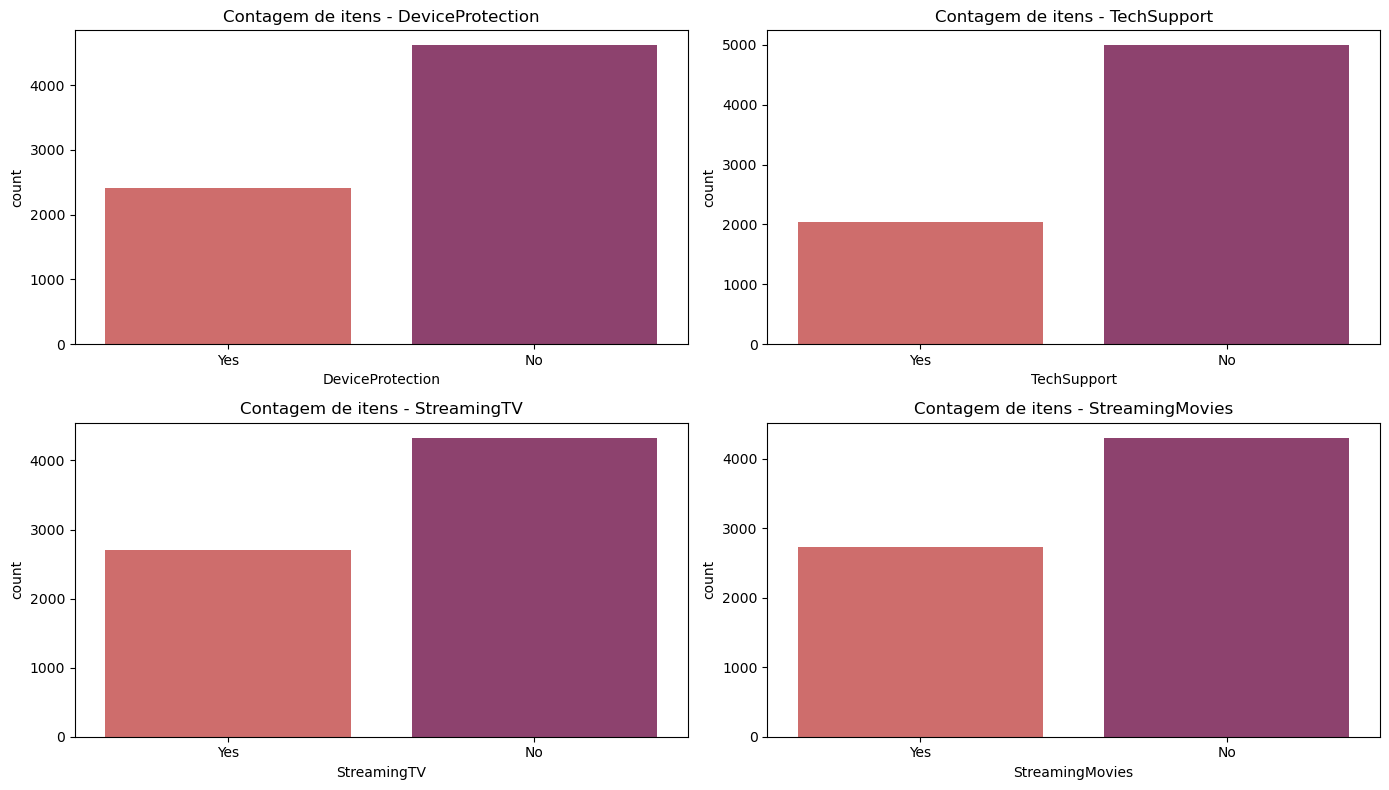

In [26]:
fig, axes = plt.subplots(2,2, figsize=(14,8))
cols = ['DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for i,j in enumerate(cols):
    x,y = divmod(i, 2)
    sns.countplot(data = df1, x = j, palette='flare', ax = axes[x,y]);
    axes[x,y].set_title('Contagem de itens - '+ j)

plt.tight_layout();

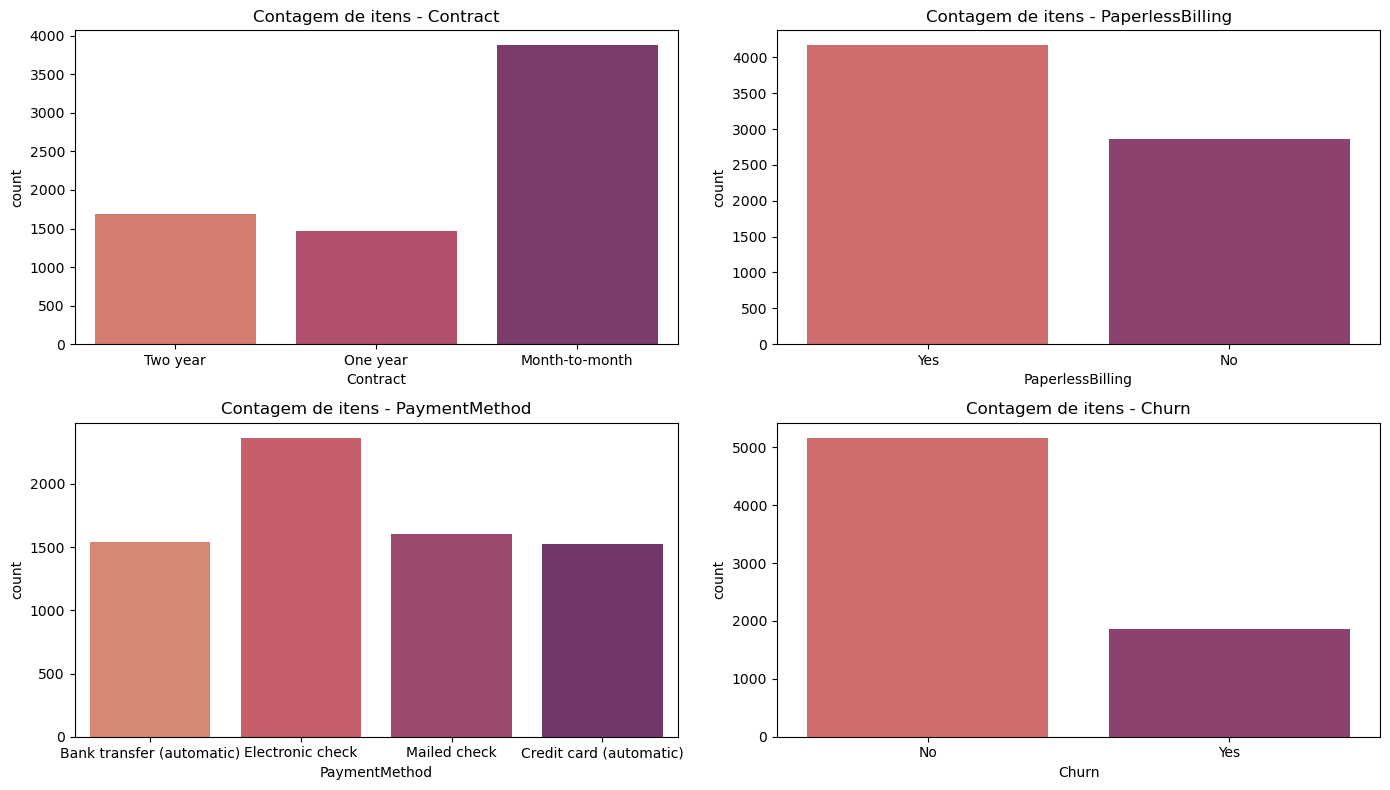

In [27]:
fig, axes = plt.subplots(2,2, figsize=(14,8))
cols = ['Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
for i,j in enumerate(cols):
    x,y = divmod(i, 2)
    sns.countplot(data = df1, x = j, palette='flare', ax = axes[x,y]);
    axes[x,y].set_title('Contagem de itens - '+ j)

plt.tight_layout();

# Data Filtering

In [28]:
df2 = df1.copy()
df2.shape

(7032, 21)

In [29]:
df2.to_parquet('../data/churn_telecom_filtered.parquet',engine='fastparquet')

# Feature Engineering

In [30]:
try:
    df3 = df2.copy()
    df3.shape
except:
    df3 = pd.read_parquet('../data/raw/cardio_without_outliers.parquet')